# Pendulum with Structured LNN and Control
- We know the data is angle and use it as advantage

## TODO:

- Plot Mass Matrix
- Plot Potential
- Understand the control

In [1]:
import numpy as np
import torch

import sys
import time
sys.path.append("../../")

## Train Model

In [2]:
# hparams
num_sample = 10000
batch_size = 512
portion = 0.5

learning_rate = 3e-4
min_delta = 0
patience = 30

time_horizon = 5
solver = 'rk4'

model_name = 'latent2.pt'
# Check Model params in Model section

### Set Seed Here

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

### Load the data set
- init_condition: list of tuple

 [(x0, p0, t0, t1, steps)]

In [4]:
from gym_env import PendulumCustomEnv
from data import Gym_DataModule_rng

In [5]:
env = PendulumCustomEnv(full_phase=True)
low = np.array([-2])
high = -low

# env, time step, traj, control
dataModule = Gym_DataModule_rng(env,
                                num_sample,
                                low=low,
                                high=high,
                                no_act_portion=portion,
                                time_horizon=time_horizon,
                                batch_size=batch_size,
                                data_dir='../../data/dataset',
                                use_img=True)

dataModule.setup()

In [6]:
print(dataModule.dataset.tensors[0].shape)  # (bs, time, [cos q, sin, q, dq])
print(dataModule.dataset.tensors[1].shape)  # (bs, time, [control])
print(dataModule.dataset.tensors[2].shape)  # (bs, time, [time])
print(dataModule.dataset.tensors[3].shape)  # (bs, time, [th, dth, ddth])
print(dataModule.dataset.tensors[4].shape)  # (bs, time, images)

torch.Size([10000, 5, 3])
torch.Size([10000, 5, 1])
torch.Size([10000, 5, 1])
torch.Size([10000, 5, 3])
torch.Size([10000, 5, 28, 28, 2])


### Define Model

In [7]:
from torchdyn.models import NeuralODE

from module.LNNODE_latent import LNNODE_latent
from nn import MLP, PSD, MatrixNet

In [8]:
massMatrixNet = PSD([1, 64, 64, 1], activation='relu')
potentialNet = MLP([1, 64, 64, 1], activation='relu')
controlNet = MatrixNet([1, 64, 64, 1], control_dim=1, activation='relu')
# controlNet = MatrixNet([1, 1], control_dim=1, activation='relu')

lagFunc = LNNODE_latent(num_angle=0, 
                        massMatrixNet=massMatrixNet,
                        potentialNet=potentialNet,
                        controlNet=controlNet)

lagODE = NeuralODE(lagFunc, sensitivity='adjoint', solver=solver).to(device)

In [9]:
torch.save(lagODE, 'models/before_{}'.format(model_name))

### Define Pytorch lightning trainer

In [10]:
import torch.nn.functional as F

import pytorch_lightning as pl

from pytorch_lightning.callbacks import EarlyStopping

In [11]:
class Learner(pl.LightningModule):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model
        self.loss_func = F.mse_loss

    def forward(self, x):
        return self.model.defunc(0, x)

    def training_step(self, batch, batch_idx):
        _, u, t, info, imgs = batch
        t_span = t[0, :, 0]
        bs = imgs.shape[0]
        time_horizon = t.shape[1]

        imgs_flatten = imgs.reshape(bs * time_horizon, -1)
        imgs_distM = torch.cdist(imgs_flatten, imgs_flatten, p=2)

        imgs_time_flatten = imgs.reshape(bs, time_horizon, 28 * 28 * 2)

        z = self.model.defunc.m.encoder(imgs_time_flatten)
        z0 = z[:, 0, :]
        z0_u = torch.cat([z0, u[:, 0, :]], dim=1)

        zest = self.model.trajectory(z0_u, t_span).transpose(0, 1)[:, :, :-1]

        z_error = self.loss_func(zest, z)

        imgs_hat = self.model.defunc.m.decoder(zest).reshape(bs, time_horizon, 28, 28, 2)

        recon_loss = self.loss_func(imgs, imgs_hat)

        zest_flatten = zest.reshape(bs * time_horizon, -1)
        zest_distM = torch.cdist(zest_flatten, zest_flatten, p=2)

        dimg_hat = imgs_hat[:, 1:, :, :, 0] - imgs_hat[:, :-1, :, :, 0]
        dimg_loss = self.loss_func(dimg_hat, imgs_hat[:, 1:, :, :, 1])

        dist_loss = self.loss_func(torch.nn.functional.normalize(imgs_distM),
                                   torch.nn.functional.normalize(zest_distM))

        loss = recon_loss * 8 + dist_loss * 1024 + z_error * 32

        self.logger.experiment.add_scalars("loss", {"train": loss}, self.current_epoch)
        return {'loss': loss, 'recon_loss': recon_loss, 'dist_loss': dist_loss, 'dimg_loss': dimg_loss, 'zerr': z_error}
    
    def validation_step(self, batch, batch_idx):
        _, u, t, info, imgs = batch
        t_span = t[0, :, 0]
        bs = imgs.shape[0]
        time_horizon = t.shape[1]

        imgs_flatten = imgs.reshape(bs * time_horizon, -1)
        imgs_distM = torch.cdist(imgs_flatten, imgs_flatten, p=2)

        imgs_time_flatten = imgs.reshape(bs, time_horizon, 28 * 28 * 2)

        z = self.model.defunc.m.encoder(imgs_time_flatten)
        z0 = z[:, 0, :]
        z0_u = torch.cat([z0, u[:, 0, :]], dim=1)

        zest = self.model.trajectory(z0_u, t_span).transpose(0, 1)[:, :, :-1]

        z_error = self.loss_func(zest, z)

        imgs_hat = self.model.defunc.m.decoder(zest).reshape(bs, time_horizon, 28, 28, 2)

        recon_loss = self.loss_func(imgs, imgs_hat)

        zest_flatten = zest.reshape(bs * time_horizon, -1)
        zest_distM = torch.cdist(zest_flatten, zest_flatten, p=2)

        dimg_hat = imgs_hat[:, 1:, :, :, 0] - imgs_hat[:, :-1, :, :, 0]
        dimg_loss = self.loss_func(dimg_hat, imgs_hat[:, 1:, :, :, 1])

        dist_loss = self.loss_func(torch.nn.functional.normalize(imgs_distM),
                                   torch.nn.functional.normalize(zest_distM))

        loss = recon_loss * 8 + dist_loss * 1024 + z_error * 32
        
        self.log('val_loss', loss)
        self.logger.experiment.add_scalars("loss", {"val": loss}, self.current_epoch)
        return {'loss': loss, 'recon_loss': recon_loss, 'dist_loss': dist_loss, 'dimg_loss': dimg_loss, 'zerr': z_error}


    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=learning_rate)
    
    def training_epoch_end(self, outputs):
        print("\n recon: {:3e}, dist {:3e}, dimg {:3e}, zerr {:3e} \n".format(outputs[-1]['recon_loss'],
                                                                              outputs[-1]['dist_loss'],
                                                                              outputs[-1]['dimg_loss'],
                                                                              outputs[-1]['zerr']))

In [12]:
learn = Learner(lagODE)

early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=min_delta, patience=patience)
trainer = pl.Trainer(callbacks=[early_stopping], min_epochs=500, max_epochs=5000)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


### Train

In [13]:
start_time = time.time()

In [14]:
trainer.fit(learn, dataModule)


  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 1.7 M 
------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.749     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:348: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to impro

Training: 0it [00:00, ?it/s]


 recon: 4.080722e-03, dist 1.082460e-04, dimg 1.071711e-04, zerr 2.287067e-04 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.105
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(



 recon: 3.947570e-03, dist 1.026384e-04, dimg 1.998691e-05, zerr 1.455879e-04 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0. New best score: 0.098



 recon: 3.804176e-03, dist 1.011478e-04, dimg 4.130421e-06, zerr 9.361781e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0. New best score: 0.095



 recon: 3.936173e-03, dist 9.905274e-05, dimg 1.800051e-06, zerr 8.213715e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 0.094



 recon: 3.811819e-03, dist 9.776247e-05, dimg 1.237263e-06, zerr 6.445865e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.832895e-03, dist 9.758891e-05, dimg 1.312533e-06, zerr 6.548134e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 0.093



 recon: 3.881041e-03, dist 9.836347e-05, dimg 1.328494e-06, zerr 5.334692e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.810605e-03, dist 9.965665e-05, dimg 1.264895e-06, zerr 6.483854e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.846679e-03, dist 9.938372e-05, dimg 1.244377e-06, zerr 5.145808e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.093



 recon: 3.840167e-03, dist 9.844294e-05, dimg 1.136467e-06, zerr 4.356358e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 0.092



 recon: 3.906568e-03, dist 9.942724e-05, dimg 1.061225e-06, zerr 5.164785e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.092



 recon: 3.795123e-03, dist 9.719074e-05, dimg 1.229354e-06, zerr 5.104309e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.813832e-03, dist 9.860534e-05, dimg 1.468260e-06, zerr 4.446600e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.861781e-03, dist 9.602023e-05, dimg 1.356934e-06, zerr 4.340913e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.091



 recon: 3.796546e-03, dist 9.628646e-05, dimg 1.580090e-06, zerr 3.443046e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.801069e-03, dist 9.583673e-05, dimg 1.123943e-06, zerr 3.522128e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.899681e-03, dist 9.794220e-05, dimg 1.525173e-06, zerr 3.580370e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.826595e-03, dist 9.802592e-05, dimg 1.393469e-06, zerr 4.072224e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.873784e-03, dist 9.698154e-05, dimg 1.188271e-06, zerr 3.948300e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.091



 recon: 3.850298e-03, dist 9.810864e-05, dimg 1.392152e-06, zerr 4.247459e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.899253e-03, dist 9.813650e-05, dimg 1.236923e-06, zerr 4.038321e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.801469e-03, dist 9.592683e-05, dimg 1.685278e-06, zerr 3.580585e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.091



 recon: 3.854556e-03, dist 9.694691e-05, dimg 1.757631e-06, zerr 3.721775e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.091



 recon: 3.853449e-03, dist 9.651707e-05, dimg 1.709669e-06, zerr 3.250144e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.786889e-03, dist 9.784499e-05, dimg 2.299876e-06, zerr 3.609334e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.788767e-03, dist 9.772881e-05, dimg 2.436053e-06, zerr 3.896277e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.091



 recon: 3.777104e-03, dist 9.706113e-05, dimg 1.564144e-06, zerr 3.486560e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.759690e-03, dist 9.522943e-05, dimg 1.773002e-06, zerr 3.067238e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.091



 recon: 3.776114e-03, dist 9.738703e-05, dimg 1.698692e-06, zerr 3.421492e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.091



 recon: 3.781836e-03, dist 9.559837e-05, dimg 1.684252e-06, zerr 3.132947e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.090



 recon: 3.794810e-03, dist 9.609049e-05, dimg 1.938576e-06, zerr 2.857141e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.090



 recon: 3.725824e-03, dist 9.708229e-05, dimg 2.191312e-06, zerr 2.911121e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.090



 recon: 3.698875e-03, dist 9.690009e-05, dimg 1.816230e-06, zerr 2.931689e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.697139e-03, dist 9.582198e-05, dimg 2.345771e-06, zerr 3.036647e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.090



 recon: 3.713547e-03, dist 9.544193e-05, dimg 2.315598e-06, zerr 2.836043e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.090



 recon: 3.798405e-03, dist 9.516161e-05, dimg 2.627147e-06, zerr 2.925933e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.747408e-03, dist 9.504663e-05, dimg 3.101189e-06, zerr 2.954329e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.089



 recon: 3.750177e-03, dist 9.495013e-05, dimg 2.837437e-06, zerr 2.647981e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.781657e-03, dist 9.465559e-05, dimg 3.518794e-06, zerr 2.956430e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.089



 recon: 3.670592e-03, dist 9.459940e-05, dimg 3.449543e-06, zerr 2.949876e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.696740e-03, dist 9.512277e-05, dimg 3.592226e-06, zerr 2.482112e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.089



 recon: 3.727190e-03, dist 9.535618e-05, dimg 3.272157e-06, zerr 2.615157e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.755168e-03, dist 9.640129e-05, dimg 3.154267e-06, zerr 2.795298e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.642706e-03, dist 9.505991e-05, dimg 3.719006e-06, zerr 2.579551e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.089



 recon: 3.715384e-03, dist 9.614120e-05, dimg 3.930147e-06, zerr 2.701862e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.661744e-03, dist 9.494338e-05, dimg 3.954142e-06, zerr 2.418627e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.089



 recon: 3.655016e-03, dist 9.520676e-05, dimg 3.828063e-06, zerr 2.608831e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.634741e-03, dist 9.599246e-05, dimg 3.662147e-06, zerr 3.001883e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.684353e-03, dist 9.548692e-05, dimg 3.924146e-06, zerr 2.762012e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.089



 recon: 3.714946e-03, dist 9.525179e-05, dimg 3.736982e-06, zerr 2.972323e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.650643e-03, dist 9.664765e-05, dimg 3.708672e-06, zerr 2.749550e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.089



 recon: 3.654191e-03, dist 9.510116e-05, dimg 3.919057e-06, zerr 2.294509e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.701129e-03, dist 9.390810e-05, dimg 3.829676e-06, zerr 2.668693e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.675429e-03, dist 9.548592e-05, dimg 3.811025e-06, zerr 2.093512e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.684563e-03, dist 9.571035e-05, dimg 4.416082e-06, zerr 2.606942e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.088



 recon: 3.675681e-03, dist 9.524520e-05, dimg 4.418087e-06, zerr 2.407286e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.088



 recon: 3.716294e-03, dist 9.684809e-05, dimg 4.171738e-06, zerr 2.668823e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.682696e-03, dist 9.546441e-05, dimg 4.508015e-06, zerr 2.924415e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.589550e-03, dist 9.540949e-05, dimg 4.315054e-06, zerr 2.657456e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.667769e-03, dist 9.752374e-05, dimg 4.544847e-06, zerr 2.705255e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.576678e-03, dist 9.505793e-05, dimg 4.233277e-06, zerr 2.433673e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.622489e-03, dist 9.623580e-05, dimg 5.006948e-06, zerr 2.704072e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.726524e-03, dist 9.638930e-05, dimg 5.625741e-06, zerr 2.644772e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.594135e-03, dist 9.543535e-05, dimg 4.795669e-06, zerr 2.479056e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.088



 recon: 3.661516e-03, dist 9.575524e-05, dimg 5.077413e-06, zerr 2.515639e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.555423e-03, dist 9.488912e-05, dimg 5.353681e-06, zerr 2.441387e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.538021e-03, dist 9.518914e-05, dimg 4.907441e-06, zerr 2.562000e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.088



 recon: 3.561664e-03, dist 9.596360e-05, dimg 4.766051e-06, zerr 2.671942e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.563578e-03, dist 9.419740e-05, dimg 5.486474e-06, zerr 2.287236e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.587566e-03, dist 9.534742e-05, dimg 5.370369e-06, zerr 2.221045e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.088



 recon: 3.646566e-03, dist 9.529584e-05, dimg 5.697857e-06, zerr 2.132091e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.587628e-03, dist 9.466380e-05, dimg 5.783611e-06, zerr 2.260456e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.554681e-03, dist 9.492775e-05, dimg 5.421890e-06, zerr 1.995623e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.087



 recon: 3.552658e-03, dist 9.518130e-05, dimg 5.389356e-06, zerr 2.203647e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.527307e-03, dist 9.603540e-05, dimg 4.973926e-06, zerr 2.410559e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.551987e-03, dist 9.552122e-05, dimg 5.267894e-06, zerr 2.231543e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.516827e-03, dist 9.552650e-05, dimg 5.091870e-06, zerr 2.118202e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.577861e-03, dist 9.727291e-05, dimg 5.298587e-06, zerr 2.561175e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.543785e-03, dist 9.447942e-05, dimg 5.361318e-06, zerr 2.457352e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.682225e-03, dist 9.546358e-05, dimg 5.752360e-06, zerr 2.370008e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.087



 recon: 3.590342e-03, dist 9.516314e-05, dimg 5.166057e-06, zerr 1.876678e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.454624e-03, dist 9.399622e-05, dimg 5.112504e-06, zerr 1.993271e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.579178e-03, dist 9.468788e-05, dimg 5.447571e-06, zerr 1.991348e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.531290e-03, dist 9.616551e-05, dimg 6.047022e-06, zerr 2.038872e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.087



 recon: 3.525650e-03, dist 9.551430e-05, dimg 5.389309e-06, zerr 2.146458e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.471559e-03, dist 9.374895e-05, dimg 5.687761e-06, zerr 2.271694e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.087



 recon: 3.574116e-03, dist 9.517638e-05, dimg 6.069580e-06, zerr 2.385931e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.538765e-03, dist 9.654895e-05, dimg 5.709228e-06, zerr 2.229482e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.087



 recon: 3.480050e-03, dist 9.379292e-05, dimg 5.191015e-06, zerr 1.969380e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.087



 recon: 3.604598e-03, dist 9.441716e-05, dimg 5.927635e-06, zerr 2.035480e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.524613e-03, dist 9.504967e-05, dimg 5.769939e-06, zerr 2.441669e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.516596e-03, dist 9.500646e-05, dimg 5.894583e-06, zerr 2.275336e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.494707e-03, dist 9.470433e-05, dimg 6.068537e-06, zerr 2.057342e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.087



 recon: 3.482486e-03, dist 9.411951e-05, dimg 6.017887e-06, zerr 2.398048e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.517443e-03, dist 9.560452e-05, dimg 6.182449e-06, zerr 1.851580e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.530235e-03, dist 9.458881e-05, dimg 6.295057e-06, zerr 2.720092e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.423967e-03, dist 9.598163e-05, dimg 6.474351e-06, zerr 1.872277e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.086



 recon: 3.525273e-03, dist 9.540293e-05, dimg 6.209321e-06, zerr 1.788899e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.467701e-03, dist 9.407973e-05, dimg 6.168234e-06, zerr 2.271926e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.438701e-03, dist 9.392085e-05, dimg 6.285456e-06, zerr 2.014407e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.419820e-03, dist 9.424498e-05, dimg 6.334268e-06, zerr 1.803042e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.549712e-03, dist 9.600214e-05, dimg 6.837700e-06, zerr 2.417634e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.452562e-03, dist 9.459550e-05, dimg 5.842527e-06, zerr 2.078047e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.489683e-03, dist 9.504399e-05, dimg 6.487756e-06, zerr 1.850384e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.086



 recon: 3.451126e-03, dist 9.419166e-05, dimg 6.600639e-06, zerr 1.838043e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.396107e-03, dist 9.387224e-05, dimg 6.707988e-06, zerr 1.677916e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.466165e-03, dist 9.404249e-05, dimg 7.150072e-06, zerr 2.148619e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.086



 recon: 3.479240e-03, dist 9.473608e-05, dimg 7.154014e-06, zerr 2.241393e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.384562e-03, dist 9.569534e-05, dimg 6.685631e-06, zerr 2.253776e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.086



 recon: 3.453871e-03, dist 9.435862e-05, dimg 7.054436e-06, zerr 1.964958e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.086



 recon: 3.428891e-03, dist 9.509808e-05, dimg 7.569721e-06, zerr 2.091340e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.382236e-03, dist 9.513371e-05, dimg 7.167113e-06, zerr 2.365770e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.086



 recon: 3.432862e-03, dist 9.401380e-05, dimg 7.287052e-06, zerr 1.732615e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.086



 recon: 3.451669e-03, dist 9.397572e-05, dimg 7.845423e-06, zerr 2.203993e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.397060e-03, dist 9.376664e-05, dimg 7.020071e-06, zerr 1.965938e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.444557e-03, dist 9.398573e-05, dimg 8.180227e-06, zerr 1.821233e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.086



 recon: 3.395225e-03, dist 9.398503e-05, dimg 7.057153e-06, zerr 1.968756e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.086



 recon: 3.338440e-03, dist 9.384951e-05, dimg 7.890417e-06, zerr 1.838723e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.370321e-03, dist 9.331328e-05, dimg 7.298879e-06, zerr 1.649602e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.414059e-03, dist 9.439185e-05, dimg 7.718970e-06, zerr 1.901429e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.086



 recon: 3.338772e-03, dist 9.362466e-05, dimg 7.982732e-06, zerr 1.852989e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.383658e-03, dist 9.375539e-05, dimg 7.655513e-06, zerr 1.843646e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.331228e-03, dist 9.492314e-05, dimg 7.758903e-06, zerr 2.041861e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.402334e-03, dist 9.397574e-05, dimg 8.634439e-06, zerr 2.016163e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.391221e-03, dist 9.370121e-05, dimg 8.803767e-06, zerr 1.690562e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.457851e-03, dist 9.439502e-05, dimg 8.768976e-06, zerr 2.082172e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.346017e-03, dist 9.340148e-05, dimg 7.806692e-06, zerr 1.740080e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.086



 recon: 3.427374e-03, dist 9.483423e-05, dimg 8.501182e-06, zerr 1.886148e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.446534e-03, dist 9.466722e-05, dimg 8.772477e-06, zerr 1.837837e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.452978e-03, dist 9.646773e-05, dimg 9.167861e-06, zerr 2.168994e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.373622e-03, dist 9.350545e-05, dimg 8.420375e-06, zerr 1.691567e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.410775e-03, dist 9.580626e-05, dimg 9.063404e-06, zerr 1.961879e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.307000e-03, dist 9.426057e-05, dimg 8.542217e-06, zerr 1.955641e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.086



 recon: 3.313120e-03, dist 9.368042e-05, dimg 8.975613e-06, zerr 1.855371e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.085



 recon: 3.339729e-03, dist 9.342736e-05, dimg 8.882692e-06, zerr 1.731765e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.350632e-03, dist 9.385488e-05, dimg 9.504524e-06, zerr 1.848053e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.406024e-03, dist 9.466195e-05, dimg 9.580463e-06, zerr 1.774341e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.318514e-03, dist 9.430225e-05, dimg 8.668441e-06, zerr 1.616429e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.085



 recon: 3.416328e-03, dist 9.510168e-05, dimg 9.254667e-06, zerr 1.934261e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.358862e-03, dist 9.453789e-05, dimg 9.484464e-06, zerr 1.911882e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.297312e-03, dist 9.483210e-05, dimg 9.839409e-06, zerr 1.423781e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.282270e-03, dist 9.381797e-05, dimg 9.247202e-06, zerr 1.490448e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.268043e-03, dist 9.345059e-05, dimg 8.837387e-06, zerr 1.647395e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.274625e-03, dist 9.360902e-05, dimg 9.199341e-06, zerr 1.819813e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.332906e-03, dist 9.498759e-05, dimg 9.503985e-06, zerr 1.409328e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.355811e-03, dist 9.546048e-05, dimg 1.032869e-05, zerr 1.944138e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.085



 recon: 3.329409e-03, dist 9.499723e-05, dimg 9.541599e-06, zerr 1.854976e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.334073e-03, dist 9.400044e-05, dimg 9.404432e-06, zerr 1.716120e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.310783e-03, dist 9.388470e-05, dimg 9.007033e-06, zerr 1.554198e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.325303e-03, dist 9.441133e-05, dimg 9.334251e-06, zerr 1.602002e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.340509e-03, dist 9.429314e-05, dimg 9.459608e-06, zerr 1.367641e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.268637e-03, dist 9.405508e-05, dimg 1.084789e-05, zerr 1.543334e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.347957e-03, dist 9.584739e-05, dimg 9.333342e-06, zerr 1.787680e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.242688e-03, dist 9.502361e-05, dimg 9.465222e-06, zerr 1.532072e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.330747e-03, dist 9.346464e-05, dimg 1.005849e-05, zerr 1.586294e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.273471e-03, dist 9.489737e-05, dimg 1.016369e-05, zerr 1.549340e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.085



 recon: 3.244455e-03, dist 9.391324e-05, dimg 9.732406e-06, zerr 1.714907e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.273005e-03, dist 9.400216e-05, dimg 9.823147e-06, zerr 1.382861e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.233737e-03, dist 9.392219e-05, dimg 8.829651e-06, zerr 1.470763e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.332563e-03, dist 9.402272e-05, dimg 1.035737e-05, zerr 1.812090e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.085



 recon: 3.311781e-03, dist 9.438201e-05, dimg 1.088024e-05, zerr 1.921168e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.325145e-03, dist 9.556556e-05, dimg 9.810721e-06, zerr 1.438680e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.283345e-03, dist 9.335610e-05, dimg 9.521802e-06, zerr 1.572431e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.295720e-03, dist 9.506326e-05, dimg 9.657892e-06, zerr 1.665563e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.261551e-03, dist 9.484424e-05, dimg 9.941820e-06, zerr 1.446792e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.281974e-03, dist 9.531375e-05, dimg 1.035028e-05, zerr 1.405725e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.316232e-03, dist 9.578217e-05, dimg 9.853123e-06, zerr 1.814288e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.372814e-03, dist 9.619923e-05, dimg 1.177545e-05, zerr 1.844939e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.268626e-03, dist 9.545239e-05, dimg 1.114484e-05, zerr 1.618597e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.297297e-03, dist 9.465039e-05, dimg 1.127837e-05, zerr 1.673945e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.222974e-03, dist 9.479677e-05, dimg 1.048787e-05, zerr 1.351187e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.351184e-03, dist 9.483914e-05, dimg 1.117742e-05, zerr 1.768198e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.261269e-03, dist 9.345370e-05, dimg 1.099096e-05, zerr 1.607942e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.085



 recon: 3.261470e-03, dist 9.428710e-05, dimg 1.064386e-05, zerr 1.898773e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.292589e-03, dist 9.425460e-05, dimg 1.165136e-05, zerr 1.517546e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.280676e-03, dist 9.601322e-05, dimg 1.197833e-05, zerr 1.643517e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.229738e-03, dist 9.556719e-05, dimg 1.077733e-05, zerr 1.694190e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.085



 recon: 3.255138e-03, dist 9.372080e-05, dimg 1.003716e-05, zerr 1.405224e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.277590e-03, dist 9.481180e-05, dimg 1.035895e-05, zerr 1.288546e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.316181e-03, dist 9.649563e-05, dimg 1.136623e-05, zerr 1.842711e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.238468e-03, dist 9.409720e-05, dimg 1.114871e-05, zerr 1.543665e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.220287e-03, dist 9.380941e-05, dimg 1.113125e-05, zerr 1.622046e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.247836e-03, dist 9.413280e-05, dimg 1.077847e-05, zerr 1.215342e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.085



 recon: 3.322811e-03, dist 9.470202e-05, dimg 1.274421e-05, zerr 1.564295e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.296642e-03, dist 9.501587e-05, dimg 1.026318e-05, zerr 1.443695e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.253854e-03, dist 9.363680e-05, dimg 1.190258e-05, zerr 1.364012e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.250027e-03, dist 9.529843e-05, dimg 1.128701e-05, zerr 1.528450e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.311225e-03, dist 9.503248e-05, dimg 1.236110e-05, zerr 1.806288e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.261194e-03, dist 9.359425e-05, dimg 1.122590e-05, zerr 1.523315e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.222063e-03, dist 9.586293e-05, dimg 1.000476e-05, zerr 1.693223e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.084



 recon: 3.203560e-03, dist 9.351524e-05, dimg 1.046157e-05, zerr 1.363500e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.206686e-03, dist 9.458506e-05, dimg 1.088302e-05, zerr 1.441201e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.084



 recon: 3.201466e-03, dist 9.344991e-05, dimg 1.107919e-05, zerr 1.537635e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.230046e-03, dist 9.353945e-05, dimg 1.126612e-05, zerr 1.503825e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.242369e-03, dist 9.565156e-05, dimg 1.147401e-05, zerr 1.597977e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.184580e-03, dist 9.403873e-05, dimg 1.148862e-05, zerr 1.502750e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.201883e-03, dist 9.388594e-05, dimg 1.117511e-05, zerr 1.270156e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.208076e-03, dist 9.420012e-05, dimg 1.098474e-05, zerr 1.379014e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.084



 recon: 3.258252e-03, dist 9.585526e-05, dimg 1.313571e-05, zerr 1.714285e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.170815e-03, dist 9.406396e-05, dimg 1.086750e-05, zerr 1.564142e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.227184e-03, dist 9.493130e-05, dimg 1.106532e-05, zerr 1.601637e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.084



 recon: 3.291789e-03, dist 9.365144e-05, dimg 1.236689e-05, zerr 1.258264e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.187211e-03, dist 9.348038e-05, dimg 1.167408e-05, zerr 1.298239e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.084



 recon: 3.247039e-03, dist 9.352916e-05, dimg 1.288126e-05, zerr 1.219015e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.233587e-03, dist 9.572144e-05, dimg 1.103972e-05, zerr 1.690284e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.266010e-03, dist 9.533946e-05, dimg 1.212203e-05, zerr 1.644961e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.084



 recon: 3.247811e-03, dist 9.423899e-05, dimg 1.316510e-05, zerr 1.404459e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.226466e-03, dist 9.441016e-05, dimg 1.191513e-05, zerr 1.310446e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.250293e-03, dist 9.439357e-05, dimg 1.265996e-05, zerr 1.321050e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.182797e-03, dist 9.419199e-05, dimg 1.079856e-05, zerr 1.538148e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.290028e-03, dist 9.462049e-05, dimg 1.230837e-05, zerr 1.528664e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.246260e-03, dist 9.411013e-05, dimg 1.295273e-05, zerr 1.452727e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.183658e-03, dist 9.462401e-05, dimg 1.139423e-05, zerr 1.397934e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.159610e-03, dist 9.392772e-05, dimg 1.159202e-05, zerr 1.526089e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.238766e-03, dist 9.422594e-05, dimg 1.322927e-05, zerr 1.376570e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.239930e-03, dist 9.524264e-05, dimg 1.271410e-05, zerr 1.591411e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.084



 recon: 3.171613e-03, dist 9.462234e-05, dimg 1.187934e-05, zerr 1.637044e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.176817e-03, dist 9.374896e-05, dimg 1.228179e-05, zerr 1.296306e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.084



 recon: 3.153194e-03, dist 9.404305e-05, dimg 1.189329e-05, zerr 1.552009e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.195021e-03, dist 9.347450e-05, dimg 1.213315e-05, zerr 1.316527e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.184902e-03, dist 9.392522e-05, dimg 1.280770e-05, zerr 1.574574e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.218480e-03, dist 9.410861e-05, dimg 1.357335e-05, zerr 1.504459e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.084



 recon: 3.237587e-03, dist 9.440515e-05, dimg 1.476667e-05, zerr 1.551407e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.183516e-03, dist 9.449030e-05, dimg 1.245223e-05, zerr 1.721859e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.263112e-03, dist 9.408625e-05, dimg 1.324487e-05, zerr 1.370418e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.168137e-03, dist 9.294901e-05, dimg 1.272403e-05, zerr 1.685375e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.219003e-03, dist 9.604391e-05, dimg 1.391945e-05, zerr 1.789466e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.221710e-03, dist 9.419001e-05, dimg 1.323232e-05, zerr 1.154470e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.194554e-03, dist 9.335111e-05, dimg 1.311787e-05, zerr 1.478980e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.123998e-03, dist 9.401338e-05, dimg 1.320552e-05, zerr 1.308757e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.084



 recon: 3.100317e-03, dist 9.369854e-05, dimg 1.318121e-05, zerr 1.660486e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.084



 recon: 3.174889e-03, dist 9.340491e-05, dimg 1.488849e-05, zerr 1.413813e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.117564e-03, dist 9.417335e-05, dimg 1.321104e-05, zerr 1.263389e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.224434e-03, dist 9.616146e-05, dimg 1.269228e-05, zerr 1.835328e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.140335e-03, dist 9.351564e-05, dimg 1.236475e-05, zerr 1.350893e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.145749e-03, dist 9.451056e-05, dimg 1.371136e-05, zerr 1.908763e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.233173e-03, dist 9.456143e-05, dimg 1.378150e-05, zerr 1.509621e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.191590e-03, dist 9.316879e-05, dimg 1.468407e-05, zerr 1.589590e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.178874e-03, dist 9.403542e-05, dimg 1.274829e-05, zerr 1.471782e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.148571e-03, dist 9.431499e-05, dimg 1.446761e-05, zerr 1.233683e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.100154e-03, dist 9.360506e-05, dimg 1.335645e-05, zerr 1.621103e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.130715e-03, dist 9.499678e-05, dimg 1.338532e-05, zerr 1.571322e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.142682e-03, dist 9.339358e-05, dimg 1.393273e-05, zerr 1.357470e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.125099e-03, dist 9.372962e-05, dimg 1.240230e-05, zerr 1.441055e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.148664e-03, dist 9.365463e-05, dimg 1.464919e-05, zerr 1.509981e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.064717e-03, dist 9.295453e-05, dimg 1.295089e-05, zerr 1.361651e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.109819e-03, dist 9.407195e-05, dimg 1.369284e-05, zerr 1.169457e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.112807e-03, dist 9.354748e-05, dimg 1.449373e-05, zerr 1.580859e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.084



 recon: 3.100632e-03, dist 9.273364e-05, dimg 1.384678e-05, zerr 1.344148e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.084



 recon: 3.184388e-03, dist 9.340937e-05, dimg 1.524623e-05, zerr 1.600264e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.097697e-03, dist 9.466206e-05, dimg 1.473838e-05, zerr 1.691695e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.136460e-03, dist 9.408255e-05, dimg 1.471271e-05, zerr 1.712564e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.170604e-03, dist 9.487673e-05, dimg 1.461858e-05, zerr 1.511552e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.084



 recon: 3.108209e-03, dist 9.361658e-05, dimg 1.411236e-05, zerr 1.286367e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.158738e-03, dist 9.499708e-05, dimg 1.332997e-05, zerr 1.666626e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.102185e-03, dist 9.503766e-05, dimg 1.539780e-05, zerr 1.480022e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.002693e-03, dist 9.337709e-05, dimg 1.547463e-05, zerr 1.204072e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.154727e-03, dist 9.509485e-05, dimg 1.617509e-05, zerr 1.295377e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.127197e-03, dist 9.489714e-05, dimg 1.583082e-05, zerr 1.600387e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.198972e-03, dist 9.451692e-05, dimg 1.827830e-05, zerr 1.378768e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.114207e-03, dist 9.414698e-05, dimg 1.506714e-05, zerr 1.434396e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.084



 recon: 3.052148e-03, dist 9.471612e-05, dimg 1.456583e-05, zerr 1.505939e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.175100e-03, dist 9.501851e-05, dimg 1.775459e-05, zerr 1.630692e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.083



 recon: 3.045340e-03, dist 9.380069e-05, dimg 1.474452e-05, zerr 1.654402e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.083



 recon: 3.118959e-03, dist 9.545861e-05, dimg 1.616691e-05, zerr 1.384010e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.130784e-03, dist 9.546462e-05, dimg 1.747525e-05, zerr 1.666588e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.045284e-03, dist 9.379630e-05, dimg 1.570021e-05, zerr 1.499108e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.083



 recon: 3.145409e-03, dist 9.408835e-05, dimg 1.589525e-05, zerr 1.775459e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.103190e-03, dist 9.587473e-05, dimg 1.657396e-05, zerr 1.630480e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.091840e-03, dist 9.475761e-05, dimg 1.697645e-05, zerr 1.709066e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.018805e-03, dist 9.418652e-05, dimg 1.545772e-05, zerr 1.459272e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.128172e-03, dist 9.434990e-05, dimg 1.556024e-05, zerr 1.637373e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.042262e-03, dist 9.465791e-05, dimg 1.533849e-05, zerr 1.878048e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.098483e-03, dist 9.399672e-05, dimg 1.659814e-05, zerr 1.661988e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.157374e-03, dist 9.518622e-05, dimg 1.775515e-05, zerr 1.658796e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.083



 recon: 3.107087e-03, dist 9.494575e-05, dimg 1.558161e-05, zerr 1.652567e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.124893e-03, dist 9.501389e-05, dimg 1.685808e-05, zerr 1.577987e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.078317e-03, dist 9.370100e-05, dimg 1.863126e-05, zerr 1.502579e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.082657e-03, dist 9.433948e-05, dimg 1.790998e-05, zerr 1.615633e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.024405e-03, dist 9.448720e-05, dimg 1.573387e-05, zerr 1.701256e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.107197e-03, dist 9.519185e-05, dimg 1.775031e-05, zerr 1.591964e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.103395e-03, dist 9.399881e-05, dimg 1.669979e-05, zerr 1.766903e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.039558e-03, dist 9.364902e-05, dimg 1.644700e-05, zerr 1.482765e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.057177e-03, dist 9.428916e-05, dimg 1.715301e-05, zerr 1.426138e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.049963e-03, dist 9.365630e-05, dimg 1.877851e-05, zerr 1.346848e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.098698e-03, dist 9.457066e-05, dimg 1.710582e-05, zerr 1.448078e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.011053e-03, dist 9.263380e-05, dimg 1.723271e-05, zerr 1.431983e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.084305e-03, dist 9.425957e-05, dimg 1.748172e-05, zerr 1.390377e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.132418e-03, dist 9.424305e-05, dimg 1.989281e-05, zerr 1.374362e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.984345e-03, dist 9.322944e-05, dimg 1.675933e-05, zerr 1.567368e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.052178e-03, dist 9.442873e-05, dimg 1.629509e-05, zerr 1.374580e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.083



 recon: 3.136037e-03, dist 9.461204e-05, dimg 1.884487e-05, zerr 1.658818e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.061237e-03, dist 9.462595e-05, dimg 1.902471e-05, zerr 1.741403e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.019819e-03, dist 9.564247e-05, dimg 1.907246e-05, zerr 1.826457e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.033566e-03, dist 9.371966e-05, dimg 1.884102e-05, zerr 1.802555e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.083



 recon: 3.021409e-03, dist 9.358458e-05, dimg 1.905209e-05, zerr 1.673394e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.070321e-03, dist 9.439747e-05, dimg 2.015232e-05, zerr 1.448822e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.106854e-03, dist 9.520591e-05, dimg 2.049443e-05, zerr 1.866979e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.030003e-03, dist 9.459409e-05, dimg 1.954609e-05, zerr 1.637756e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.995674e-03, dist 9.544459e-05, dimg 1.815157e-05, zerr 1.654519e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.984352e-03, dist 9.268679e-05, dimg 1.944993e-05, zerr 1.638930e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.083



 recon: 3.086412e-03, dist 9.459430e-05, dimg 1.966590e-05, zerr 1.338956e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.007364e-03, dist 9.340696e-05, dimg 2.071322e-05, zerr 1.576672e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.074240e-03, dist 9.403998e-05, dimg 2.038876e-05, zerr 1.631476e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.083



 recon: 3.058372e-03, dist 9.296199e-05, dimg 2.018768e-05, zerr 1.556686e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.067794e-03, dist 9.510030e-05, dimg 2.020010e-05, zerr 1.564325e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.038720e-03, dist 9.527963e-05, dimg 2.051880e-05, zerr 1.565279e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.999904e-03, dist 9.469823e-05, dimg 2.113603e-05, zerr 2.018931e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.965227e-03, dist 9.374879e-05, dimg 2.043308e-05, zerr 1.451302e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.979393e-03, dist 9.417534e-05, dimg 1.963857e-05, zerr 1.482495e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.951192e-03, dist 9.385905e-05, dimg 2.060398e-05, zerr 1.889264e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.040962e-03, dist 9.388714e-05, dimg 2.358314e-05, zerr 1.874386e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.022065e-03, dist 9.349822e-05, dimg 2.177891e-05, zerr 1.350557e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.992149e-03, dist 9.408087e-05, dimg 2.133755e-05, zerr 1.815135e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.029779e-03, dist 9.461048e-05, dimg 2.371300e-05, zerr 1.820863e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.008575e-03, dist 9.398117e-05, dimg 2.298937e-05, zerr 1.503099e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.017261e-03, dist 9.398815e-05, dimg 2.128892e-05, zerr 1.490909e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.938708e-03, dist 9.424458e-05, dimg 2.012150e-05, zerr 1.614649e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.083



 recon: 2.990004e-03, dist 9.517581e-05, dimg 2.196434e-05, zerr 1.641310e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.015252e-03, dist 9.386903e-05, dimg 2.238705e-05, zerr 1.550106e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.994577e-03, dist 9.320023e-05, dimg 2.220080e-05, zerr 1.563852e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.981954e-03, dist 9.494646e-05, dimg 2.129891e-05, zerr 1.752969e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.926959e-03, dist 9.270563e-05, dimg 2.220361e-05, zerr 1.777902e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.034049e-03, dist 9.495400e-05, dimg 2.683010e-05, zerr 1.482157e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.941439e-03, dist 9.419574e-05, dimg 2.157089e-05, zerr 1.738807e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.001414e-03, dist 9.448201e-05, dimg 2.366041e-05, zerr 1.630259e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.969935e-03, dist 9.428719e-05, dimg 2.339506e-05, zerr 1.546384e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.961185e-03, dist 9.354557e-05, dimg 2.425937e-05, zerr 1.533531e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.941021e-03, dist 9.366628e-05, dimg 2.406704e-05, zerr 1.601040e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.042576e-03, dist 9.388047e-05, dimg 2.534000e-05, zerr 1.415333e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.989314e-03, dist 9.447928e-05, dimg 2.412740e-05, zerr 1.834484e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.082



 recon: 3.034806e-03, dist 9.399286e-05, dimg 2.451232e-05, zerr 1.711282e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.929302e-03, dist 9.372827e-05, dimg 2.362833e-05, zerr 1.568028e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.082



 recon: 2.962011e-03, dist 9.481488e-05, dimg 2.459777e-05, zerr 1.565466e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.082



 recon: 3.015681e-03, dist 9.458265e-05, dimg 2.513626e-05, zerr 1.622030e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.049270e-03, dist 9.412722e-05, dimg 2.898146e-05, zerr 1.809620e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.976951e-03, dist 9.449784e-05, dimg 2.703348e-05, zerr 1.953954e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.962586e-03, dist 9.309450e-05, dimg 2.462907e-05, zerr 1.573508e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.082



 recon: 2.984430e-03, dist 9.484232e-05, dimg 2.623188e-05, zerr 1.642000e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.049611e-03, dist 9.432648e-05, dimg 2.617906e-05, zerr 1.800868e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.979861e-03, dist 9.376444e-05, dimg 2.525211e-05, zerr 1.695727e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.983321e-03, dist 9.405108e-05, dimg 2.523671e-05, zerr 1.896489e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.994109e-03, dist 9.386583e-05, dimg 2.666625e-05, zerr 1.573779e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.975543e-03, dist 9.332115e-05, dimg 2.731661e-05, zerr 1.599174e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.937525e-03, dist 9.341328e-05, dimg 2.386690e-05, zerr 1.642706e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.951059e-03, dist 9.363740e-05, dimg 2.607405e-05, zerr 1.648689e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.855395e-03, dist 9.373245e-05, dimg 2.457137e-05, zerr 1.316473e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.082



 recon: 2.917741e-03, dist 9.421088e-05, dimg 2.521591e-05, zerr 1.631048e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.887645e-03, dist 9.384722e-05, dimg 2.581256e-05, zerr 1.341263e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.952026e-03, dist 9.377563e-05, dimg 2.608050e-05, zerr 1.662655e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.082



 recon: 2.843556e-03, dist 9.307215e-05, dimg 2.464786e-05, zerr 1.650105e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.922576e-03, dist 9.383947e-05, dimg 2.483377e-05, zerr 1.878681e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.928061e-03, dist 9.425937e-05, dimg 2.441016e-05, zerr 1.469502e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.082



 recon: 2.991480e-03, dist 9.495107e-05, dimg 2.561596e-05, zerr 1.720896e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.938552e-03, dist 9.409245e-05, dimg 2.610156e-05, zerr 1.722658e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.876880e-03, dist 9.384434e-05, dimg 2.684176e-05, zerr 1.632941e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.082



 recon: 2.982922e-03, dist 9.363263e-05, dimg 2.787612e-05, zerr 1.838075e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.839562e-03, dist 9.337391e-05, dimg 2.484291e-05, zerr 1.330501e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.930346e-03, dist 9.496292e-05, dimg 2.802746e-05, zerr 1.615775e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.938136e-03, dist 9.449525e-05, dimg 2.774994e-05, zerr 1.803264e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.950233e-03, dist 9.424501e-05, dimg 2.699144e-05, zerr 1.988095e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.960030e-03, dist 9.468223e-05, dimg 2.787521e-05, zerr 1.646590e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.082



 recon: 2.908409e-03, dist 9.349694e-05, dimg 2.604051e-05, zerr 1.646338e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.937598e-03, dist 9.357820e-05, dimg 2.867069e-05, zerr 1.634580e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.985840e-03, dist 9.488623e-05, dimg 2.756795e-05, zerr 1.628446e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.952686e-03, dist 9.301156e-05, dimg 2.870926e-05, zerr 1.394799e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.806639e-03, dist 9.514365e-05, dimg 2.532315e-05, zerr 1.703810e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.879843e-03, dist 9.413615e-05, dimg 2.657425e-05, zerr 1.407257e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.924796e-03, dist 9.389579e-05, dimg 2.879597e-05, zerr 1.855917e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.854074e-03, dist 9.349451e-05, dimg 2.855290e-05, zerr 1.697702e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.832232e-03, dist 9.237972e-05, dimg 2.537210e-05, zerr 1.650754e-05 



Validating: 0it [00:00, ?it/s]


 recon: 3.019954e-03, dist 9.468243e-05, dimg 3.047376e-05, zerr 1.644616e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.924780e-03, dist 9.422881e-05, dimg 2.834210e-05, zerr 1.498966e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.937800e-03, dist 9.433873e-05, dimg 2.653233e-05, zerr 1.596424e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.959358e-03, dist 9.384395e-05, dimg 2.869595e-05, zerr 1.979027e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.837763e-03, dist 9.319984e-05, dimg 2.693801e-05, zerr 1.603723e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.082



 recon: 2.892092e-03, dist 9.360960e-05, dimg 2.811436e-05, zerr 1.633879e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.845319e-03, dist 9.362520e-05, dimg 2.811803e-05, zerr 1.483044e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.923324e-03, dist 9.378264e-05, dimg 2.599818e-05, zerr 1.599161e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.951691e-03, dist 9.344094e-05, dimg 2.856549e-05, zerr 1.623048e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.082



 recon: 2.851273e-03, dist 9.289810e-05, dimg 2.647507e-05, zerr 1.422306e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.856410e-03, dist 9.415608e-05, dimg 2.772318e-05, zerr 1.649150e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.872853e-03, dist 9.376846e-05, dimg 2.784185e-05, zerr 1.829808e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.901285e-03, dist 9.726905e-05, dimg 2.905177e-05, zerr 1.479191e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.875474e-03, dist 9.398324e-05, dimg 3.146631e-05, zerr 1.594162e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.895457e-03, dist 9.351780e-05, dimg 2.943758e-05, zerr 1.714389e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.961661e-03, dist 9.482017e-05, dimg 2.904912e-05, zerr 1.739552e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.927173e-03, dist 9.518748e-05, dimg 2.835511e-05, zerr 1.330180e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.946345e-03, dist 9.380746e-05, dimg 2.867945e-05, zerr 1.783770e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.807076e-03, dist 9.441662e-05, dimg 2.625102e-05, zerr 1.588351e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.900219e-03, dist 9.566155e-05, dimg 2.851329e-05, zerr 1.662061e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.836618e-03, dist 9.432366e-05, dimg 2.851322e-05, zerr 1.586251e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.891484e-03, dist 9.366312e-05, dimg 3.055346e-05, zerr 1.324066e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.863875e-03, dist 9.419234e-05, dimg 3.161369e-05, zerr 1.517704e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.895821e-03, dist 9.447269e-05, dimg 2.928952e-05, zerr 1.424995e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.907800e-03, dist 9.356300e-05, dimg 2.976458e-05, zerr 1.543031e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.840000e-03, dist 9.401498e-05, dimg 2.836644e-05, zerr 1.390208e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.932886e-03, dist 9.487080e-05, dimg 3.399847e-05, zerr 1.716041e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.871719e-03, dist 9.551123e-05, dimg 2.957903e-05, zerr 1.318695e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.819414e-03, dist 9.469620e-05, dimg 2.645485e-05, zerr 1.361146e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.865693e-03, dist 9.331307e-05, dimg 3.066881e-05, zerr 1.783498e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.925810e-03, dist 9.452176e-05, dimg 3.201109e-05, zerr 1.653687e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.953177e-03, dist 9.447029e-05, dimg 3.215975e-05, zerr 1.610670e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.844854e-03, dist 9.323262e-05, dimg 2.946926e-05, zerr 1.478156e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.905333e-03, dist 9.354348e-05, dimg 3.161938e-05, zerr 1.451334e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.812898e-03, dist 9.404328e-05, dimg 3.283454e-05, zerr 1.414730e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.913110e-03, dist 9.473226e-05, dimg 3.311604e-05, zerr 1.606598e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.900702e-03, dist 9.371032e-05, dimg 3.293013e-05, zerr 1.365984e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.818234e-03, dist 9.378033e-05, dimg 2.822205e-05, zerr 1.519294e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.966340e-03, dist 9.403798e-05, dimg 3.267349e-05, zerr 1.578110e-05 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 30 records. Best score: 0.082. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.850269e-03, dist 9.498299e-05, dimg 3.248443e-05, zerr 1.361473e-05 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 31 records. Best score: 0.082. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.868938e-03, dist 9.391807e-05, dimg 3.222518e-05, zerr 1.665543e-05 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 32 records. Best score: 0.082. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.881794e-03, dist 9.359173e-05, dimg 3.088500e-05, zerr 1.591008e-05 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 33 records. Best score: 0.082. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.850996e-03, dist 9.483550e-05, dimg 2.927249e-05, zerr 1.534796e-05 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 34 records. Best score: 0.082. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.901862e-03, dist 9.448011e-05, dimg 3.212203e-05, zerr 1.505089e-05 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 35 records. Best score: 0.082. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.925228e-03, dist 9.398215e-05, dimg 3.324640e-05, zerr 1.613294e-05 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 36 records. Best score: 0.082. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.866026e-03, dist 9.378468e-05, dimg 3.148230e-05, zerr 1.528424e-05 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 37 records. Best score: 0.082. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.837945e-03, dist 9.358583e-05, dimg 3.206602e-05, zerr 1.450193e-05 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 38 records. Best score: 0.082. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.813466e-03, dist 9.311944e-05, dimg 3.098788e-05, zerr 1.550001e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.082



 recon: 2.838258e-03, dist 9.399100e-05, dimg 2.921191e-05, zerr 1.710451e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.804261e-03, dist 9.324474e-05, dimg 3.060341e-05, zerr 1.569240e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.858547e-03, dist 9.441185e-05, dimg 2.979297e-05, zerr 1.616638e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.830929e-03, dist 9.315879e-05, dimg 3.015850e-05, zerr 1.863080e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.866209e-03, dist 9.342199e-05, dimg 3.187907e-05, zerr 1.531442e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.082



 recon: 2.846611e-03, dist 9.349875e-05, dimg 2.997620e-05, zerr 1.555612e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.082



 recon: 2.932613e-03, dist 9.447879e-05, dimg 3.386362e-05, zerr 1.392266e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.792804e-03, dist 9.293427e-05, dimg 3.159006e-05, zerr 1.424097e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.819151e-03, dist 9.478672e-05, dimg 3.163474e-05, zerr 1.410284e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.926182e-03, dist 9.615764e-05, dimg 3.489173e-05, zerr 1.843458e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.779876e-03, dist 9.290419e-05, dimg 2.904790e-05, zerr 1.449572e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.939314e-03, dist 9.519850e-05, dimg 3.395705e-05, zerr 1.746148e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.911076e-03, dist 9.510006e-05, dimg 3.309729e-05, zerr 1.590787e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.927573e-03, dist 9.400948e-05, dimg 3.342818e-05, zerr 1.767213e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.826330e-03, dist 9.334285e-05, dimg 3.048291e-05, zerr 1.447484e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.869438e-03, dist 9.348362e-05, dimg 3.314027e-05, zerr 1.296314e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.832076e-03, dist 9.404544e-05, dimg 3.359914e-05, zerr 1.604993e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.867442e-03, dist 9.522847e-05, dimg 3.508962e-05, zerr 1.572300e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.769696e-03, dist 9.308693e-05, dimg 3.011000e-05, zerr 1.532149e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.859308e-03, dist 9.415797e-05, dimg 3.258318e-05, zerr 1.144044e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.842552e-03, dist 9.296650e-05, dimg 3.361475e-05, zerr 1.450194e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.865130e-03, dist 9.351448e-05, dimg 3.321147e-05, zerr 1.450117e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.865741e-03, dist 9.303487e-05, dimg 3.226249e-05, zerr 1.299234e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.864273e-03, dist 9.555615e-05, dimg 3.299739e-05, zerr 1.679564e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.829178e-03, dist 9.365649e-05, dimg 3.429610e-05, zerr 1.764367e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.835877e-03, dist 9.394933e-05, dimg 3.263391e-05, zerr 1.652991e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.830508e-03, dist 9.373593e-05, dimg 3.128122e-05, zerr 1.441081e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.082



 recon: 2.784673e-03, dist 9.303210e-05, dimg 3.068733e-05, zerr 1.473817e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.840308e-03, dist 9.436147e-05, dimg 3.001177e-05, zerr 1.440324e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.833616e-03, dist 9.342409e-05, dimg 2.961830e-05, zerr 1.627848e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.738363e-03, dist 9.330935e-05, dimg 3.040311e-05, zerr 1.391510e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.871232e-03, dist 9.486765e-05, dimg 3.333795e-05, zerr 1.537540e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.923942e-03, dist 9.510355e-05, dimg 3.443297e-05, zerr 1.670752e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.843023e-03, dist 9.375784e-05, dimg 3.534279e-05, zerr 1.671688e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.758787e-03, dist 9.325638e-05, dimg 3.273135e-05, zerr 1.457809e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.902335e-03, dist 9.525075e-05, dimg 3.381344e-05, zerr 1.534412e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.871224e-03, dist 9.449532e-05, dimg 3.381811e-05, zerr 1.504070e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.799199e-03, dist 9.318897e-05, dimg 3.169779e-05, zerr 1.298056e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.800392e-03, dist 9.443811e-05, dimg 3.370555e-05, zerr 1.492348e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.831608e-03, dist 9.335610e-05, dimg 3.520748e-05, zerr 1.450687e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.938208e-03, dist 9.485033e-05, dimg 3.406899e-05, zerr 1.640857e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.082



 recon: 2.849571e-03, dist 9.338446e-05, dimg 3.570946e-05, zerr 1.362830e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.844085e-03, dist 9.418673e-05, dimg 3.365428e-05, zerr 1.350126e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.879041e-03, dist 9.347364e-05, dimg 3.541272e-05, zerr 1.545146e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.855388e-03, dist 9.395719e-05, dimg 3.199726e-05, zerr 1.484338e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.802272e-03, dist 9.320361e-05, dimg 3.240662e-05, zerr 1.451069e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.765543e-03, dist 9.319738e-05, dimg 3.262131e-05, zerr 1.189444e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.808711e-03, dist 9.402156e-05, dimg 3.335680e-05, zerr 1.799645e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.853842e-03, dist 9.378795e-05, dimg 3.253216e-05, zerr 1.465211e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.877533e-03, dist 9.371404e-05, dimg 3.406544e-05, zerr 1.284277e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.860674e-03, dist 9.267151e-05, dimg 3.656080e-05, zerr 1.594384e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.840360e-03, dist 9.373721e-05, dimg 3.353179e-05, zerr 1.475188e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.718370e-03, dist 9.350719e-05, dimg 3.073767e-05, zerr 1.341574e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.751120e-03, dist 9.431755e-05, dimg 3.170516e-05, zerr 1.662114e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.720173e-03, dist 9.253434e-05, dimg 3.128379e-05, zerr 1.318765e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.082



 recon: 2.755754e-03, dist 9.270076e-05, dimg 3.406953e-05, zerr 1.493773e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.886348e-03, dist 9.474504e-05, dimg 3.804949e-05, zerr 1.585583e-05 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.082



 recon: 2.751415e-03, dist 9.315956e-05, dimg 3.374784e-05, zerr 1.254402e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.767662e-03, dist 9.394778e-05, dimg 3.291349e-05, zerr 1.397758e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.750628e-03, dist 9.396574e-05, dimg 3.262580e-05, zerr 1.738773e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.843451e-03, dist 9.413408e-05, dimg 3.487327e-05, zerr 1.498395e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.772928e-03, dist 9.385532e-05, dimg 3.155441e-05, zerr 1.172177e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.806819e-03, dist 9.411667e-05, dimg 3.402723e-05, zerr 1.783221e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.780380e-03, dist 9.334675e-05, dimg 3.406552e-05, zerr 1.348846e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.838108e-03, dist 9.477719e-05, dimg 3.627269e-05, zerr 1.348990e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.782322e-03, dist 9.384166e-05, dimg 3.475264e-05, zerr 1.418288e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.849012e-03, dist 9.387096e-05, dimg 3.287773e-05, zerr 1.618316e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.788822e-03, dist 9.429136e-05, dimg 3.610114e-05, zerr 1.513907e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.796300e-03, dist 9.361700e-05, dimg 3.447879e-05, zerr 1.263624e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.814315e-03, dist 9.496753e-05, dimg 3.335301e-05, zerr 1.544775e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.889172e-03, dist 9.409044e-05, dimg 3.652292e-05, zerr 1.412134e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.815583e-03, dist 9.558989e-05, dimg 3.711360e-05, zerr 1.315286e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.866810e-03, dist 9.470143e-05, dimg 3.594475e-05, zerr 1.636118e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.772598e-03, dist 9.373715e-05, dimg 3.520719e-05, zerr 1.696170e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.782106e-03, dist 9.464009e-05, dimg 3.701034e-05, zerr 1.533940e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.776986e-03, dist 9.445364e-05, dimg 3.845200e-05, zerr 1.679403e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.834966e-03, dist 9.423714e-05, dimg 3.547915e-05, zerr 1.436805e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.868430e-03, dist 9.336333e-05, dimg 3.733673e-05, zerr 1.657195e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.819399e-03, dist 9.284635e-05, dimg 3.525657e-05, zerr 1.446006e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.771926e-03, dist 9.306195e-05, dimg 3.379290e-05, zerr 1.499110e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.822500e-03, dist 9.478640e-05, dimg 3.585151e-05, zerr 1.558308e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.710985e-03, dist 9.310494e-05, dimg 3.558734e-05, zerr 1.179060e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.823493e-03, dist 9.375286e-05, dimg 4.068486e-05, zerr 1.588771e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.816070e-03, dist 9.399468e-05, dimg 3.555683e-05, zerr 1.286292e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.814478e-03, dist 9.359052e-05, dimg 3.537375e-05, zerr 1.450248e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.759343e-03, dist 9.340474e-05, dimg 3.567662e-05, zerr 1.324993e-05 



Validating: 0it [00:00, ?it/s]


 recon: 2.754919e-03, dist 9.578437e-05, dimg 3.411697e-05, zerr 1.555293e-05 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 30 records. Best score: 0.082. Signaling Trainer to stop.


In [15]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 9468.374433994293 seconds ---


### Save Model
- Pytorch Lightning model check point is buggy
- Use Pytorch save and load method instead

In [16]:
torch.save(lagODE, 'models/{}'.format(model_name))

## Model Analysis

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

### Load Model

In [18]:
test_model = torch.load('models/{}'.format(model_name))
test_model.eval()

test_model = test_model

### Generate trajectory with Gym Env

In [19]:
# define testing time stamp
dt = 0.05
full = 200
t_span = torch.linspace(dt, dt*full, full)

In [20]:
import cv2
def preproc_pend(img):
    gray = cv2.cvtColor(img[220: 780, 220: 780, :], cv2.COLOR_BGR2GRAY)  # Grey Scale
    img = cv2.resize(gray, [28, 28])  # Rescale image
    img[img == 255] = 0  # Black background (0 seems better for training)
    output = img / 255
    return output

In [21]:
# Generate Trajectory
env.seed(0)
np.random.seed(0)

env = PendulumCustomEnv()
obs = []
infos = []
images = []

# control = 2
# controls = np.random.randint(-2, 2 + 1, full+1)
split = 20
controls = np.random.randint(-2, 2 + 1, int(full / split))
controls = np.repeat(controls, split)
controls = np.zeros_like(controls)

# obs0, _ = env.reset(np.array([3., 1.]))
obs0, _ = env.reset(np.array([np.pi / 2, 0.]))

prev_obs = obs0
prev_img = env.render('rgb_array')

for i in range(full):
    obs.append(prev_obs)
    images.append(preproc_pend(prev_img))
    
    next_obs, reward, done, info = env.step(controls[i])
    next_img = env.render('rgb_array')
    
    infos.append(np.array([info['th'], info['dth'], info['ddth']]))
    
    prev_obs = next_obs
    prev_img = next_img

obs = torch.tensor(obs)
infos = torch.tensor(infos)
imgs = torch.tensor(images)
controls = torch.Tensor(controls).view(-1, 1)
env.close()

### Generate Prediction

In [22]:
P = imgs[1:, :, :]
dP = imgs[1:, :, :] -imgs[: -1, :, :]
P_dP = torch.stack([P, dP], dim=3)

In [23]:
dataModule.dataset.tensors[4].shape

torch.Size([10000, 5, 28, 28, 2])

In [24]:
z = test_model.defunc.m.encoder(P_dP.reshape(1, full-1, -1).float())
# z_raw = test_model.defunc.m.encoder(dataModule.dataset.tensors[4].reshape(10000, 10, -1).float())

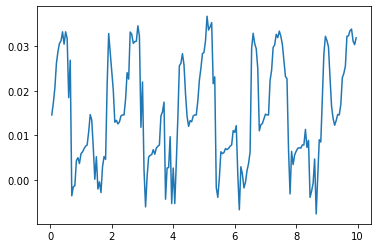

In [25]:
plt.plot(t_span[:full-1].detach().numpy(), z[0, :full-1, 0].detach().numpy())
# plt.plot(t_span[:full-1].detach().numpy(), controls[:full-1])
# plt.ylim(-4, 4)

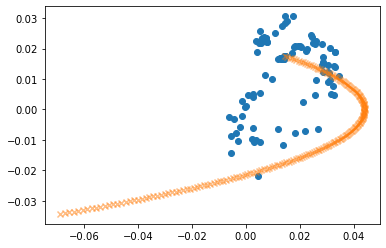

In [43]:
t = 100
plt.scatter(z[0, :t, 0].detach().numpy(), z[0, :t, 1].detach().numpy())
# plt.scatter(z_raw[0, :t, 0].detach().numpy(), z_raw[0, :t, 1].detach().numpy())
plt.scatter(est_z2[:,  0], est_z2[:, 1], marker = 'x', alpha=0.5)
# plt.xlim(-0.45, -0.35)
# plt.ylim(-0.04, 0.04)

In [27]:
from utils import traj_pred

# Generate prediction

q_dq_u = torch.cat([z[0, :, :], controls[1:, :]], dim=1)
q_dq = z[0, :]
est_grad = test_model.defunc(0, q_dq_u.float())
est_z = traj_pred(0.05, test_model, q_dq[0, :].detach().numpy(), controls)

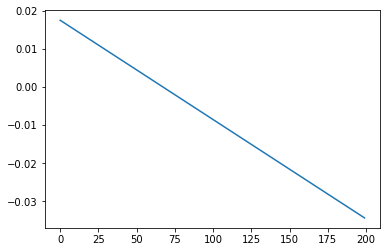

In [28]:
plt.plot(est_z.y[1, :])

In [29]:
est_z2 = torch.tensor(est_z.y.T)

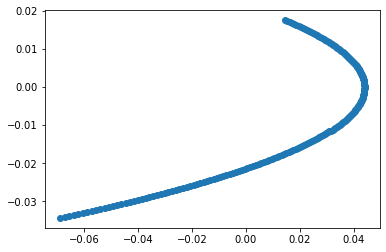

In [30]:
plt.scatter(est_z2[:, 0], est_z2[:, 1])

In [31]:
recon_img = test_model.defunc.m.decoder(est_z2.float())

In [32]:
recon_img = recon_img.reshape(full, 28, 28, 2)

<ipython-input-33-282f15ae3aa0>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(7, 3))


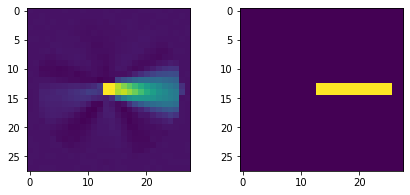

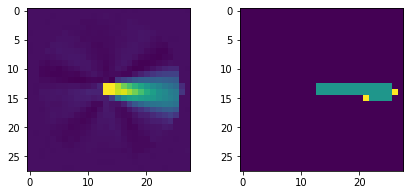

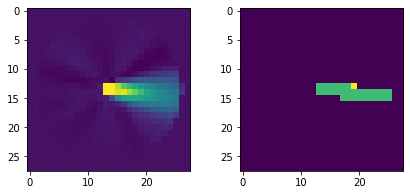

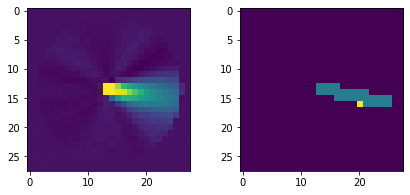

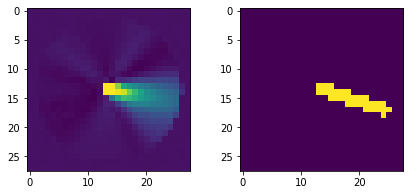

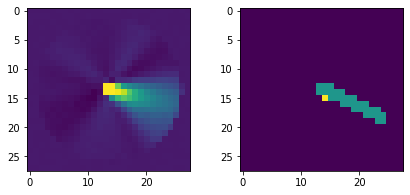

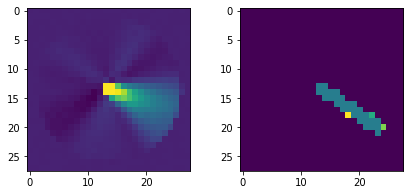

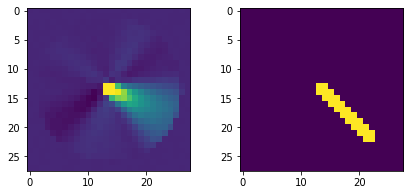

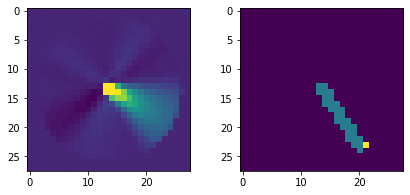

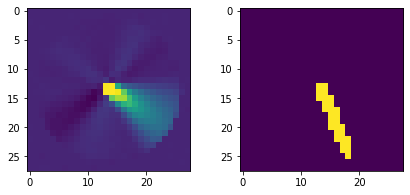

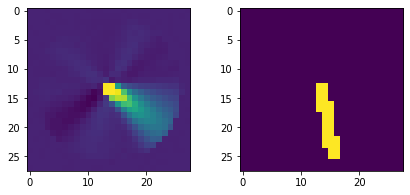

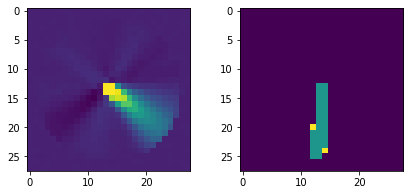

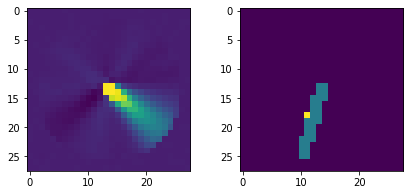

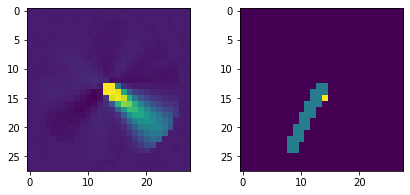

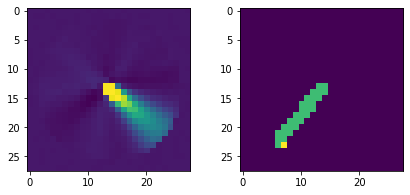

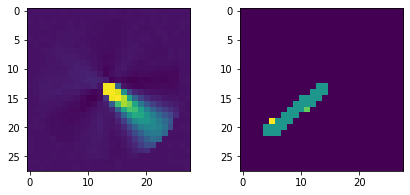

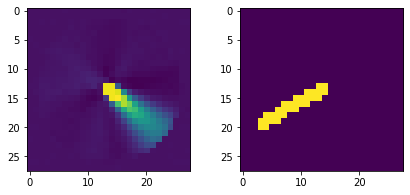

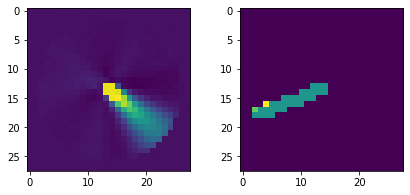

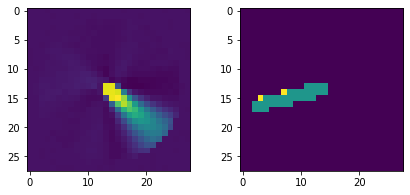

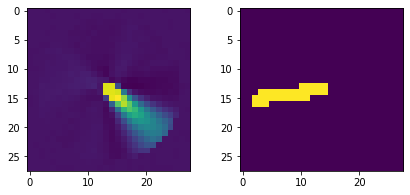

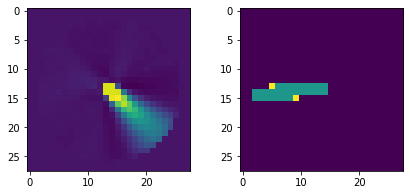

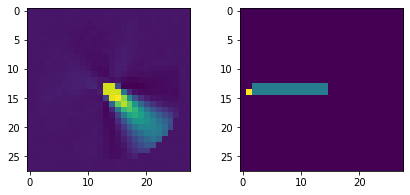

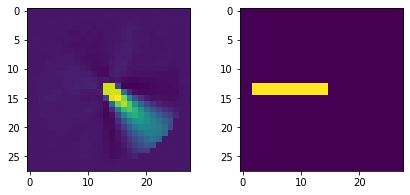

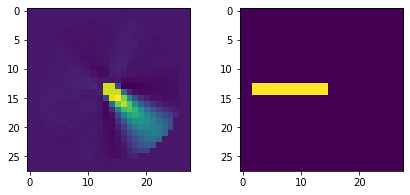

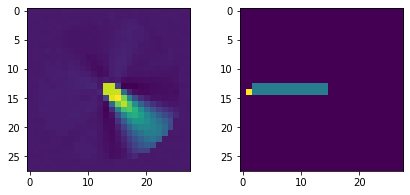

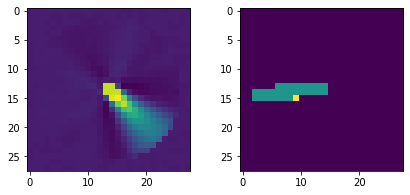

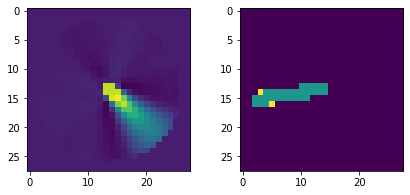

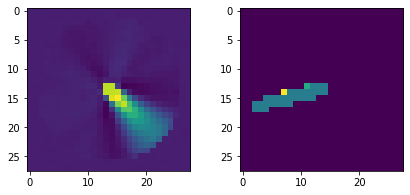

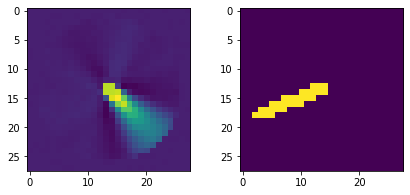

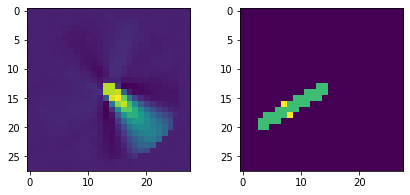

In [33]:
num_iters = 30

for i in range(num_iters):
    fig = plt.figure(figsize=(7, 3))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.imshow(recon_img[i, :, :, 0].detach().numpy())
    ax2.imshow(P_dP[i, :, :, 0].detach().numpy())

In [34]:
n_grid = 50
# x = torch.linspace(-np.pi, np.pi, n_grid)
x = torch.linspace(-0.45, -0.35, n_grid)
y = torch.linspace(-0.04, 0.04, n_grid)

Q, dQ = torch.meshgrid(x, y)  # all (q, p)

# H is Hamiltonian
# (U, V) are the symplectic gradient
L, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)

for i in range(n_grid):
    for j in range(n_grid):
        # The current canonical coordinate
        x = torch.cat([Q[i, j].reshape(1, 1), dQ[i, j].reshape(1, 1), torch.zeros(1, 1)], dim=1)
        L[i, j] = test_model.defunc.m.L(x[:, :-1]).detach().cpu()
        grad = test_model.defunc(0, x).detach().cpu()
        U[i, j], V[i, j] = grad[:, 0], grad[:, 1]

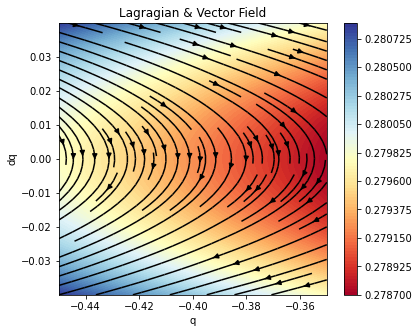

In [35]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
CS = ax.contourf(Q, dQ, L, 100, cmap='RdYlBu')
fig.colorbar(CS)

ax.streamplot(Q.T.numpy(), dQ.T.numpy(), U.T.numpy(), V.T.numpy(), color='black')

ax.set_xlim([Q.min(), Q.max()])
ax.set_ylim([dQ.min(), dQ.max()])
ax.set_xlabel("q")
ax.set_ylabel("dq")
ax.set_title("Lagragian & Vector Field")
None

In [36]:
from scipy.integrate import solve_ivp

def dummy(t, y):
    idx = int(torch.tensor(t) / dt)
    dx1 = np.multiply(-y[1], y[2])
    dx2 = np.multiply(y[0], y[2])
    ddq = -10 * y[0] + controls[idx-1] / 2.
    return [dx1, dx2, ddq]

sol = solve_ivp(dummy, [dt, dt*full], obs0, method='Radau', t_eval=t_span.detach().numpy())

In [37]:
est_grad.shape

torch.Size([199, 3])

### Check gradient

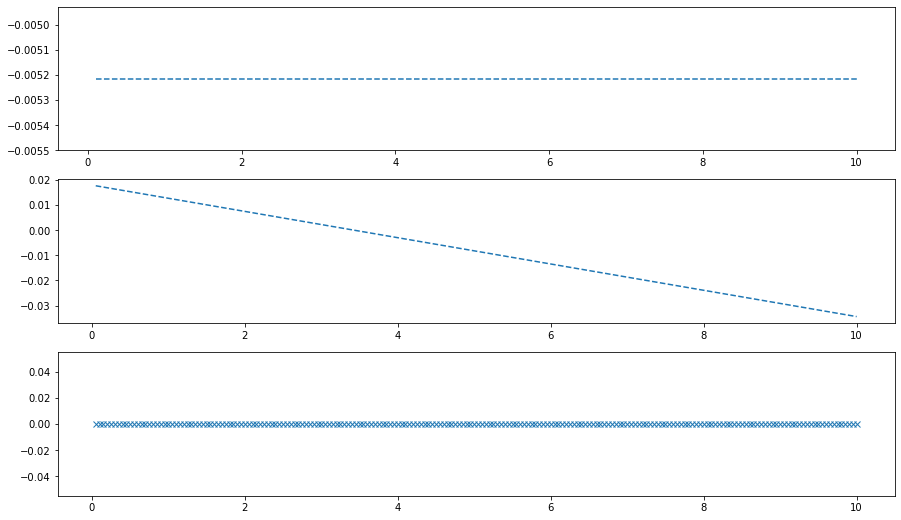

In [38]:
fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

start = 0
end = 500

# Check ddq_est
# ax1.plot(t_span.detach().numpy()[start:end], infos[start:end, 2],'x-', alpha=0.5)  # Ground truth
ax1.plot(t_span.detach().numpy()[start+1:end], est_grad[start:end, 1].detach().numpy(), '--')  # LNN

# check dq_est
# ax2.plot(t_span.detach().numpy()[start:end], infos[start:end, 1],'-', alpha=0.5)
ax2.plot(t_span.detach().numpy()[start:end], est_z2[:, 1], '--')  # LNN
# ax2.plot(sol.t[start:end], sol.y[2, start:end])

# Plot control for reference
ax3.plot(t_span.detach().numpy()[start:end], controls[start:end],'x')
# None

### Plot Mass Matrix

<ipython-input-39-12ba3b94e7ca>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q = torch.tensor(x[i])


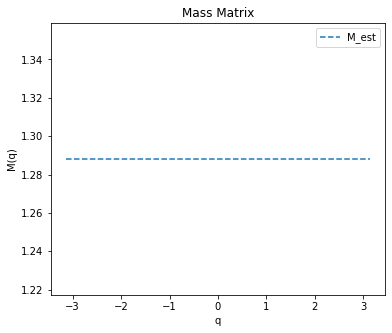

In [39]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)

M_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.tensor(x[i])
    M_est[i] = test_model.defunc.m.massMatrixNet(q.view(1, -1)).detach().cpu()[0, 0, 0]

    
M_true = torch.ones(M_est.shape)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), M_est, '--', label='M_est')
# ax.plot(x.detach().numpy(), M_true, label='M_true', alpha=0.5)

ax.legend()
# ax.set_ylim([0, 1.1])
ax.set_xlabel("q")
ax.set_ylabel("M(q)")
ax.set_title("Mass Matrix")
None

### Plot Potential

<ipython-input-40-142d41b7c392>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q = torch.tensor(x[i])


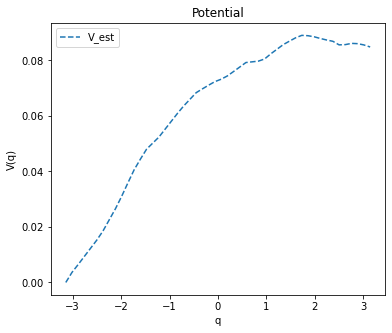

In [40]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)

V_true = 1. * 10 * torch.sin(x)

V_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.tensor(x[i])
    V_est[i] = test_model.defunc.m.potentialNet(q.view(1, -1)).detach().cpu()

V_est = V_est - min(V_est)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), V_est, '--', label='V_est')
# ax.plot(x.detach().numpy(), V_true, label='V_true', alpha=0.5)

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("V(q)")
ax.set_title("Potential")
None

### Plot Control

<ipython-input-41-9cbb3257d4ab>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q = torch.tensor(x[i])


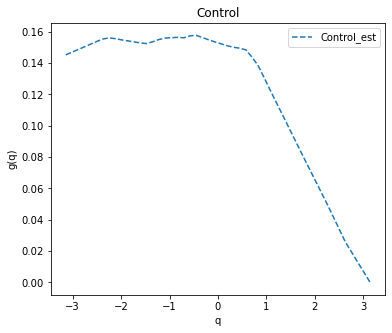

In [41]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)
x1, x2 = torch.meshgrid(x, x)  # (cos q, sin q)

Control = 1. * 10 * torch.ones_like(x)

V_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.tensor(x[i])
    V_est[i] = test_model.defunc.m.controlNet(q.view(1, -1)).detach().cpu()

V_est = V_est - min(V_est)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), V_est, '--', label='Control_est')
# ax.plot(x.detach().numpy(), V_true, label='V_true', alpha=0.5)

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("g(q)")
ax.set_title("Control")
None

## Conclusion